# $\sigma^{54}$-RNAP-Cy3 binding to 598P2993

Fig. 3D in [RNA polymerase approaches its promoter without
long-range sliding along DNA](https://www.pnas.org/content/pnas/110/24/9740.full.pdf)

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import pi, resample
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import time_to_first_binding

from tapqir.utils.stats import ci_from_trace
from tapqir.utils.mle_analysis import train, ttfb_model, ttfb_guide

## View Data

In [2]:
# load glimpse
path_data = Path("/shared/centaur/data/Larry/")
glimpse = GlimpseDataset(path_data)

# load model & parameters
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

### AOIs

In [3]:
glimpse.aoiinfo["test"]

,frame,ave,x,y,pixnum
aoi,,,,,
1,28.0,5.0,314.452808,100.175625,8.0
2,28.0,5.0,314.725694,84.978373,8.0
3,28.0,5.0,328.625477,83.399878,8.0
4,28.0,5.0,311.078359,51.571321,8.0
5,28.0,5.0,273.370180,52.027392,8.0
...,...,...,...,...,...
118,28.0,5.0,448.612006,419.915098,10.0
119,28.0,3.0,215.437014,312.936510,9.0
120,28.0,3.0,165.648914,427.485576,9.0


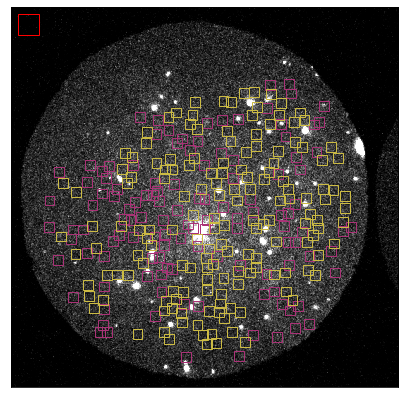

In [4]:
plt.figure(figsize=(7, 7))

frame = 2078 - 47
# plot selected area of the image
plt.imshow(glimpse[frame][:, :550], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

for aoi in glimpse.aoiinfo["control"].index:
    # off-target area
    y_pos = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))
    

plt.gca().add_patch(Rectangle((10, 10), 30, 30,
                    edgecolor="r", lw=1, facecolor="none"))
    
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Driftlist

In [5]:
glimpse.cumdrift

,dx,dy
frame,,
47,0.000000,0.000000
48,0.000242,0.000391
49,0.000484,0.000783
50,0.000727,0.001176
51,0.000973,0.001574
...,...,...
3897,1.055898,4.725019
3898,1.056138,4.725881
3899,1.056379,4.726741


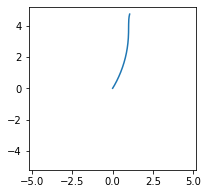

In [6]:
plt.figure(figsize=(3,3))
plt.plot(glimpse.cumdrift["dx"], glimpse.cumdrift["dy"])
lim = glimpse.cumdrift.abs().max().max() * 1.1
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

### Offset

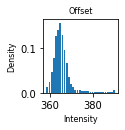

In [7]:
plt.figure(figsize=(1.35,1.35))
plt.bar(model.data.offset_samples, model.data.offset_weights)
plt.title("Offset", fontsize=8)
plt.ylabel("Density", fontsize=8)
plt.xlabel("Intensity", fontsize=8)
plt.show()

### Global parameters

In [8]:
fit = pd.read_csv(
            path_params / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename("sigma54RNAPCy3-598P2993")
fit

snr                 4.177913665771484
gain_mean          16.973125457763672
gain_ll            16.973125457763672
gain_ul            16.973125457763672
pi_mean           0.02729317545890808
pi_ll             0.02729317545890808
pi_ul             0.02729317545890808
lamda_mean        0.07792063802480698
lamda_ll          0.07792063802480698
lamda_ul          0.07792063802480698
proximity_mean    0.38665512204170227
proximity_ll      0.38665512204170227
proximity_ul      0.38665512204170227
marginal                         True
classifier                       True
MCC                0.9251518871107954
Recall              0.888881152962473
Precision          0.9674168371599606
TN                             455517
FP                                430
FN                               1596
TP                              12767
z_median           0.9724542498588562
z_ll                0.860388994216919
z_ul               0.9834402799606323
Name: sigma54RNAPCy3-598P2993, dtype: object

## Figures

### Figure 4

In [9]:
model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

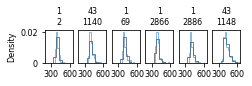

In [10]:
aois = [1, 43, 1, 1, 1, 43]
frames = [2, 1140, 69, 2866, 2886, 1148]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(200, model.data.vmax+150)
    plt.xticks([300, 600], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-hist.svg")

plt.show()

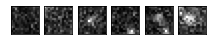

In [11]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=model.data.vmin, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-data.png", dpi=600)

plt.show()

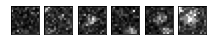

In [12]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=model.data.vmin, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-sample.png", dpi=600)

plt.show()

### Extended Data Figure 4

#### Rastegram

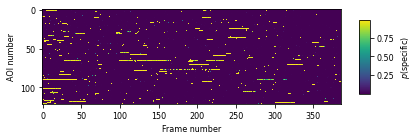

In [3]:
path_data = Path("/shared/centaur/data/Larry/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

# on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

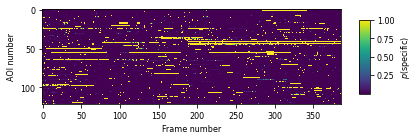

In [10]:
# off-target
plt.figure(figsize=(6, 2))
plt.imshow(1 - (1 - model.j_probs[:, :, ::10]).prod(0), aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

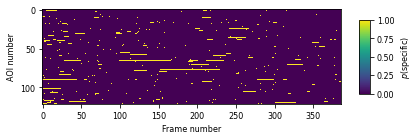

In [11]:
# spotpicker
ttfb = time_to_first_binding(model.data.labels["z"])
# sort ttfb
sdx = np.flip(np.argsort(ttfb))


plt.figure(figsize=(6, 2))
plt.imshow(model.data.labels["z"][:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

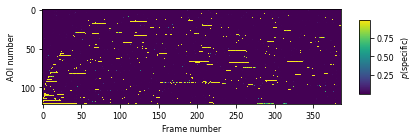

In [12]:
# sorted on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx][:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure4/598P2993-rastegram.png", dpi=900)
plt.show()

#### Tapqir fit

In [4]:
z_marginal = model.z_marginal.data
control = None
Tmax = model.data.F

z = dist.Bernoulli(z_marginal).sample((1000,))
data = time_to_first_binding(z)

In [5]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] == 1 and not strict:
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:183: TracerWarning: Converting a tensor to a Python 

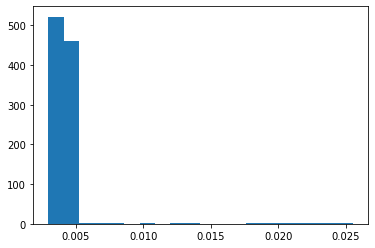

In [6]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [17]:
ka_mean = pyro.param("ka").data.mean()
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0)
ka_mean, ka_ll, ka_ul

(tensor(0.0043), tensor(0.0038), tensor(0.0045))

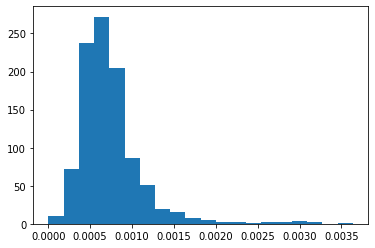

In [18]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [19]:
kns_mean = pyro.param("kns").data.mean()
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0)
kns_mean, kns_ll, kns_ul

(tensor(0.0007), tensor(0.0004), tensor(0.0010))

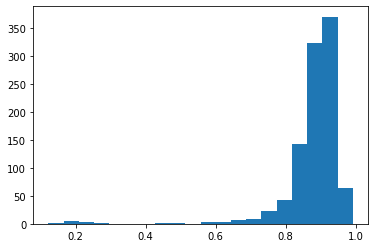

In [20]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [49]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean, Af_ll, Af_ul

(tensor(0.8204), tensor(0.8144), tensor(0.9314))

In [50]:
nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

In [51]:
fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

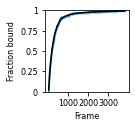

In [55]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure3/598P2993-tapqir.svg")
plt.show()

#### Spotpicker fit

In [17]:
Tmax = model.data.F

spotpicker_data = time_to_first_binding(model.data.labels["z"])
spotpicker_data = torch.tensor(spotpicker_data, dtype=torch.float)
spotpicker_control = time_to_first_binding(model.control.labels["z"])
spotpicker_control = torch.tensor(spotpicker_control, dtype=torch.float)

bootstrap_data = torch.stack(
    [resample(spotpicker_data, num_samples=len(spotpicker_data), replacement=True) for _ in range(1000)],
    dim=0
)
bootstrap_control = torch.stack(
    [resample(spotpicker_control, num_samples=len(spotpicker_control), replacement=True) for _ in range(1000)],
    dim=0
)

In [19]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=bootstrap_data, control=bootstrap_control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarn

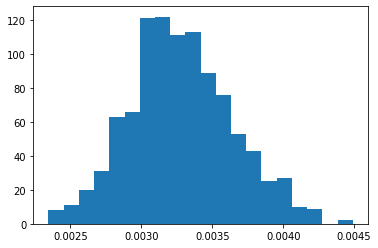

In [20]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [21]:
ka_mean = pyro.param("ka").data.mean()
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0)
ka_mean, ka_ll, ka_ul

(tensor(0.0033), tensor(0.0029), tensor(0.0036))

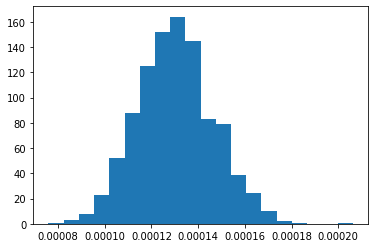

In [22]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [23]:
kns_mean = pyro.param("kns").data.mean()
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0)
kns_mean, kns_ll, kns_ul

(tensor(4.3480e-05), tensor(3.8179e-05), tensor(4.9109e-05))

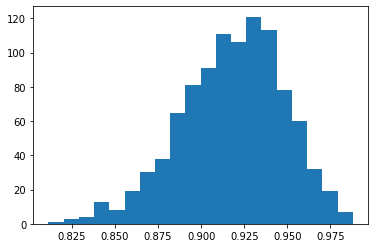

In [24]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [25]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean, Af_ll, Af_ul

(tensor(0.9182), tensor(0.8887), tensor(0.9472))

In [26]:
nz = (bootstrap_data == 0).sum(1, keepdim=True)
n = (bootstrap_data == Tmax).sum(1, keepdim=True)
N = bootstrap_data.shape[1]

nzc = (bootstrap_control == 0).sum(1, keepdim=True)
nc = (bootstrap_control == Tmax).sum(1, keepdim=True)
Nc = bootstrap_control.shape[1]

In [27]:
fraction_bound = (bootstrap_data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

fraction_boundc = (bootstrap_control.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fbc_ll, fbc_ul = pi(fraction_boundc, 0.68, dim=0)

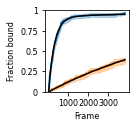

In [30]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.fill_between(
    torch.arange(Tmax),
    fbc_ll, fbc_ul,
    alpha=0.3, color="C1"
)
plt.plot(torch.arange(Tmax), fraction_boundc.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax)))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure4/598P2993-spotpicker.svg")
plt.show()